# 'Bound' Prediction Project
### by Frederic Suares

In [17]:
import sqlite3 
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)

In [18]:
# create a connection
con = sqlite3.connect("/home/frederic/InsuranceProject/insurance_ds_20211025.db")

In [19]:
cur = con.cursor()

In [20]:
# read data from SQL to pd.df
dates = pd.read_sql('Select * from dates', con);
primary = pd.read_sql('SELECT * FROM "primary"', con);
status = pd.read_sql('Select * from status', con);

In [21]:
#join via uid with SQL to save memory
policies = pd.read_sql('SELECT * from dates LEFT OUTER JOIN "primary" using (uid)\
                        LEFT OUTER JOIN "status" using (uid)', con)

In [22]:
policies.head()

,uid,SubmissionDate,EffectiveDate,AccountNumber,AgencyZipCode,InsuredZipCode,AgencyCity,AgencyState,InsuredyCity,InsuredState,AgencyTier,IndustryType,WrittenPremium,Quoted,Bound
0,1,2020-02-09,2020-04-10,498635-330,28367,99630,Norman,NC,Mekoryuk,AK,Platinum,Real Estate,5056.0,1.0,0.0
1,2,2020-09-10,2021-03-04,169285-143,71235,48864,Dubach,LA,Okemos,MI,Gold,Real Estate,16549.0,0.0,0.0
2,3,2020-06-16,2020-09-15,215075-889,78358,92868,Fulton,TX,Orange,CA,Bronze,None,3566.0,0.0,0.0
3,4,2020-03-16,2020-09-10,207085-143,65084,26452,Versailles,MO,Weston,WV,Platinum,Real Estate,3431.0,0.0,0.0
4,5,2020-02-13,2020-05-04,391712-274,44721,80820,Canton,OH,Guffey,CO,Gold,Food Processing,11942.0,1.0,0.0


In [23]:
policies = policies.drop(['uid'],axis=1)

In [24]:
policies.describe()

,WrittenPremium,Quoted,Bound
count,14892.000000,15073.000000,15073.000000
mean,11975.768869,0.550056,0.140981
std,7889.323407,0.497505,0.348013
min,1121.000000,0.000000,0.000000
25%,4715.500000,0.000000,0.000000
50%,11762.000000,1.000000,0.000000
75%,18407.250000,1.000000,0.000000
max,52258.000000,1.000000,1.000000


In [25]:
policies.dtypes

SubmissionDate     object
EffectiveDate      object
AccountNumber      object
AgencyZipCode      object
InsuredZipCode     object
AgencyCity         object
AgencyState        object
InsuredyCity       object
InsuredState       object
AgencyTier         object
IndustryType       object
WrittenPremium    float64
Quoted            float64
Bound             float64
dtype: object

Let's make the date features DateTime variables right now.

In [26]:
# Convert date columns to YYYY-MM
policies['EffectiveDate'] = pd.to_datetime(policies['EffectiveDate'], format = "%Y/%m/%d")#.dt.to_period('m')
policies['SubmissionDate'] = pd.to_datetime(policies['SubmissionDate'], format = "%Y/%m/%d")#.dt.to_period('m')

# 1. Essentials
Let's start with missing/incorrect values of features

In [27]:
nulls = policies.isnull().sum()

#show features with non-zero amount of missing values only
nulls[nulls!=0]

AgencyZipCode     272
InsuredZipCode    196
AgencyTier         76
IndustryType      121
WrittenPremium    181
dtype: int64

In [28]:
#Now as a %
nulls_percent = nulls[nulls!=0]/policies.shape[0]*100
print('The % of null values per feature:\n')
print(round(nulls_percent,2))

The % of null values per feature:

AgencyZipCode     1.8
InsuredZipCode    1.3
AgencyTier        0.5
IndustryType      0.8
WrittenPremium    1.2
dtype: float64


In [29]:
#let's look at Quoted/Bound
print(py.array([policies['Bound'] - policies['Quoted'] == 1]).sum())
policies[policies['Bound'] - policies['Quoted'] == 1].iloc[:]


8


,SubmissionDate,EffectiveDate,AccountNumber,AgencyZipCode,InsuredZipCode,AgencyCity,AgencyState,InsuredyCity,InsuredState,AgencyTier,IndustryType,WrittenPremium,Quoted,Bound
1411,2020-06-26,2020-10-03,442262-382,82935,12811,Green River,WY,Bakers Mills,NY,Gold,Real Estate,25931.0,0.0,1.0
6506,2020-12-09,2021-01-04,320109-274,97528,72930,Grants Pass,OR,Cecil,AR,Platinum,Real Estate,5741.0,0.0,1.0
7019,2020-03-27,2020-05-19,245494-324,94542,63766,Hayward,CA,Millersville,MO,Silver,Restaurants - Fast Food,3669.0,0.0,1.0
8624,2020-12-12,2021-01-05,109749-143,61744,93429,Gridley,IL,Casmalia,CA,Gold,Wholesale,3885.0,0.0,1.0
10088,2020-05-20,2020-07-06,432893-502,46035,52660,Colfax,IN,Yarmouth,IA,Platinum,Hospitality,26049.0,0.0,1.0
13454,2020-07-29,2020-09-15,253138-592,53942,16627,Lime Ridge,WI,Coalport,PA,Gold,Hospitality,2297.0,0.0,1.0
14714,2020-07-13,2020-08-20,343972-274,61068,10607,Rochelle,IL,White Plains,NY,Gold,Hospitality,1693.0,0.0,1.0
14982,2020-12-15,2021-01-29,154411-850,13659,53536,Lorraine,NY,Evansville,WI,Platinum,Real Estate,5055.0,0.0,1.0


Some observations: 
- A fairly small amount of missing features. 
- 'Bound' output variable is not missing any values, great!
- ~14.1% of policies in the dataset are bound. This is not too imbalanced
- Only 8 of 15000+ policies were entered incorrectly for Quoted vs. Bound. I don't see any pattern in the features among these 8 that would explain this error.

## 2. Feature cleaning

In [30]:
uniques = policies.nunique()
print(uniques)

SubmissionDate      366
EffectiveDate       566
AccountNumber     15036
AgencyZipCode     11776
InsuredZipCode    11945
AgencyCity         7141
AgencyState          44
InsuredyCity       7182
InsuredState         44
AgencyTier            4
IndustryType          8
WrittenPremium    10280
Quoted                2
Bound                 2
dtype: int64


Where we're headed:

- I'll drop the AccountNumber and city variables.

- I'd like to build one more variable based on time.

- Fixing sparsity in geographic variables

In [31]:
policies = policies.drop(['AgencyCity', 'InsuredyCity', 'AccountNumber'],axis=1)

In [32]:
#checking back to see what happened...
policies.nunique()

SubmissionDate      366
EffectiveDate       566
AgencyZipCode     11776
InsuredZipCode    11945
AgencyState          44
InsuredState         44
AgencyTier            4
IndustryType          8
WrittenPremium    10280
Quoted                2
Bound                 2
dtype: int64

Next, let's build that time to policy effective date variable.

The idea for this variable came from a past real estate project of mine.

In [33]:
policies['Time_To_Effective_Date'] = policies['EffectiveDate'] - policies['SubmissionDate']
policies['Time_To_Effective_Date'].describe()

count                         15073
mean     84 days 06:54:20.134014463
std      55 days 18:32:37.340829886
min                 1 days 00:00:00
25%                36 days 00:00:00
50%                77 days 00:00:00
75%               131 days 00:00:00
max               280 days 00:00:00
Name: Time_To_Effective_Date, dtype: object

I don't see any negative values, great!

In [34]:
policies['Time_To_Effective_Date'].nunique()

226

Let's look at the distribution of dates with a simple histogram:

In [35]:
policies['Time_To_Effective_Date_numeric'] = policies['Time_To_Effective_Date'].astype(int)
policies['Time_To_Effective_Date_numeric'].describe()

count    1.507300e+04
mean     7.282460e+15
std      4.818757e+15
min      8.640000e+13
25%      3.110400e+15
50%      6.652800e+15
75%      1.131840e+16
max      2.419200e+16
Name: Time_To_Effective_Date_numeric, dtype: float64

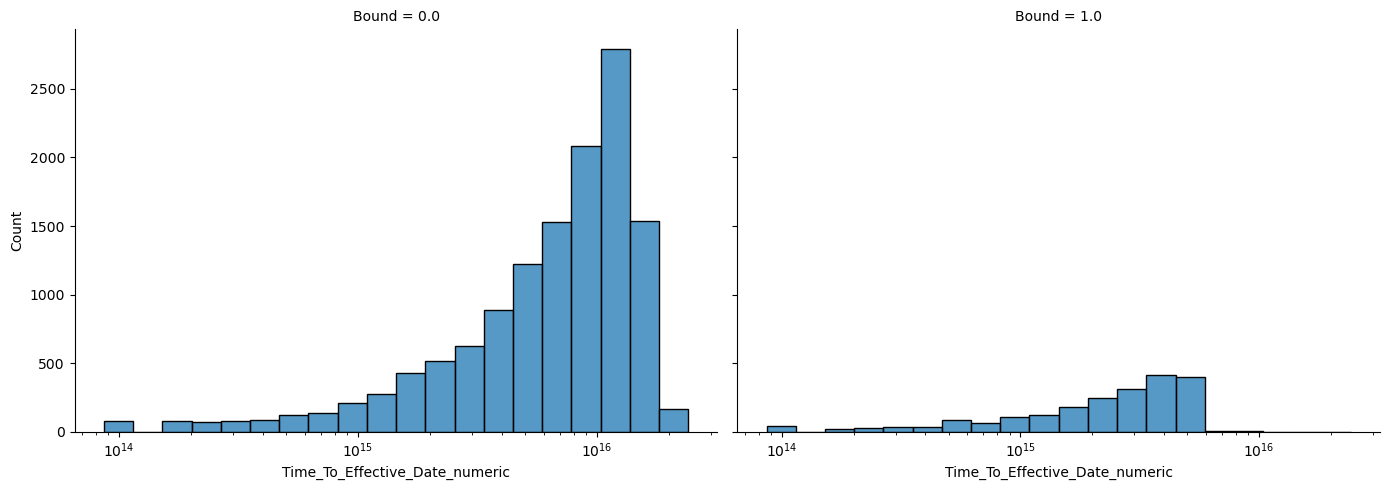

In [36]:
sns.displot(
  data=policies,
  x="Time_To_Effective_Date_numeric",
  col="Bound",
  kind="hist",
  #hue="Bound",
  #kde="true",
  aspect=1.4,
  log_scale=10,
  bins=20
)
plt.show()

Similar (bound vs. not bound) distributions with left-tail skew; this makes sense.

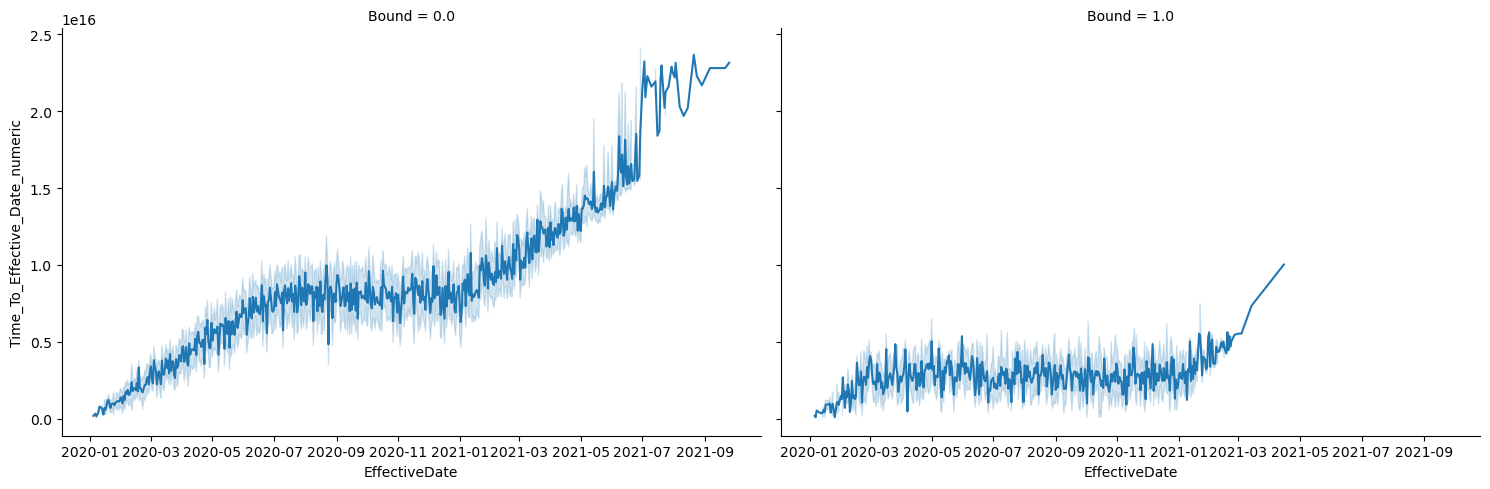

In [37]:
# Time to effective date by bound over time
sns.relplot(
    data=policies, 
    x="EffectiveDate", 
    y="Time_To_Effective_Date_numeric",
    col="Bound", 
    kind="line",
    aspect=1.5,
)
plt.show()

Similar but different. 
- Not bound means time to effective date was consistently increasing (minus covid months?)
- Bound increased at first but was mostly steady until recently
- More recent behavior is difficult to know (i.e. why Bound = 0 data goes to present time but Bound = 1 stops at May 2021)

In [38]:
# Create numeric values for date variables for heatmap & showing my new variable gives a better signal
policies['SubmissionDateNumeric'] = policies['SubmissionDate'].astype(int)
policies['EffectiveDateNumeric'] = policies['EffectiveDate'].astype(int)
# ZipCode to numeric isn't correlated in heatmap below
#policies['AgencyZipCode'] = policies['AgencyZipCode'].astype(int)

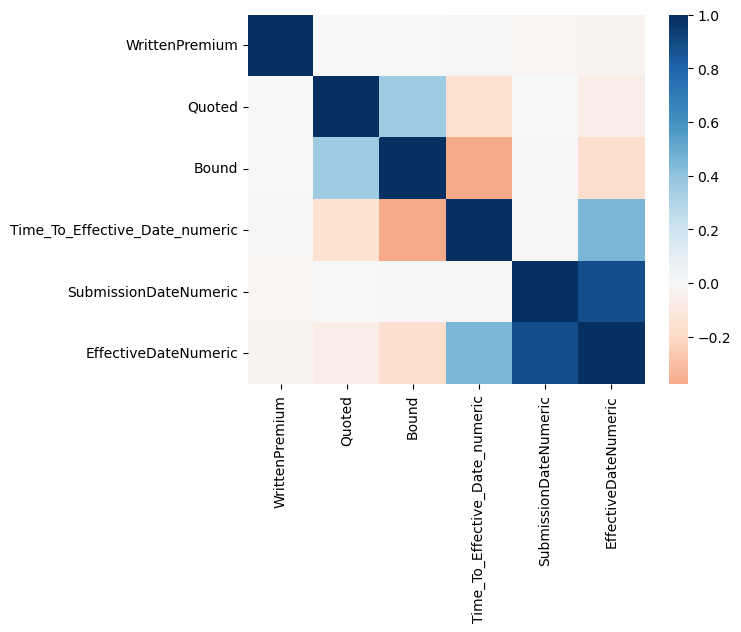

In [39]:
sns.heatmap(policies.corr(),cmap='RdBu',center=0)
plt.show()

In [40]:
policies = policies.drop(['SubmissionDateNumeric', 'EffectiveDateNumeric'],axis=1)

- My new variable has fewer categories (226 vs. 366 or 566) and is more strongly correlated to the 'Bound' outcome variable than either SubmissionDate or EffectiveDate were. 

- The writtenPremium variable doesn't seem to be correlated with the Bound variable interestingly. 

- Quoted has the highest correlation with output variable (bound). This isn't helpful though. 

Next, let's learn more about the AgencyTiers

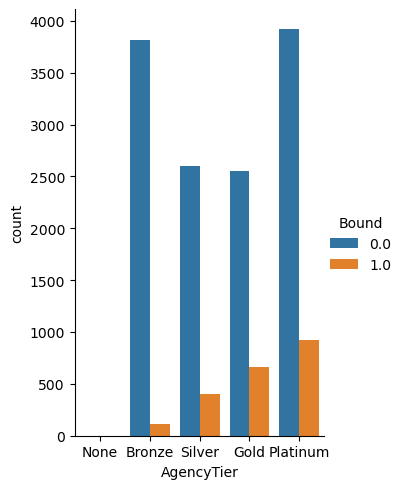

In [41]:
sns.catplot(x="AgencyTier", 
            #y="WrittenPremium", 
            hue="Bound", 
            aspect=.7, 
            kind="count",
            order=["None", "Bronze", "Silver", "Gold", "Platinum"],
            data=policies)
plt.show()

The # of bound policies increases by Tier while unbound policies do not. 

What about the overall distribution of policies by WrittenPremium?

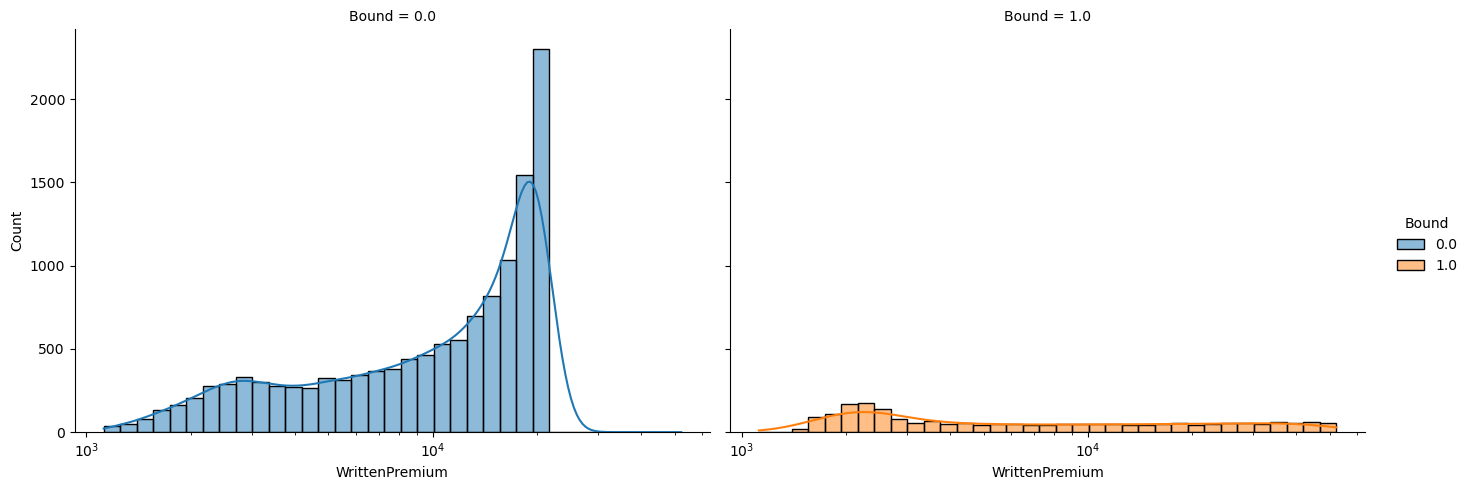

In [42]:
sns.displot(
  data=policies,
  x="WrittenPremium",
  col="Bound",
  kind="hist",
  hue="Bound",
  kde="true",
  aspect=1.4,
  log_scale=10,
  #bins=20
)
plt.show()

WrittenPremium is very differently distributed in tail, skew, uniformity, and mode(s) based on bound. 

I also tried small, per-Agency Tier plots and the distribution for the written premium was the same. I.e. the tiering does not affect how the premiums are distributed (!) 

We can get a better idea for this with boxplots...

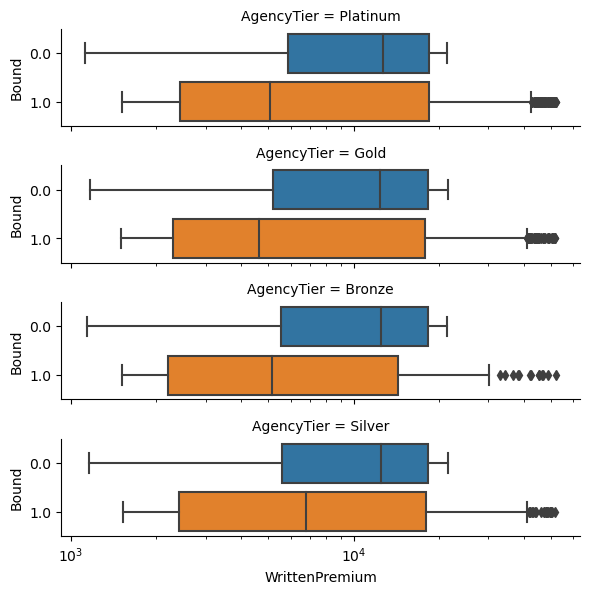

In [43]:
g = sns.catplot(x="WrittenPremium", 
                y="Bound", 
                row="AgencyTier",
                kind="box", 
                orient="h", 
                height=1.5, 
                aspect=4, 
                #order=["Bronze", "Silver", "Gold", "Platinum"],
                data=policies)
g.set(xscale="log")
plt.show()

When we break up WrittenPremium by category, we see the effect in AgencyTier only when the Bound = 1!

Also interesting to note and worth more investigation: silver has the highest median bound writtenPremium!

### 3. Zip Code analysis
I tried aggregating zipcodes on 4 and 3 digits to make them more dense, but settled on 1-hot encoding in the end; it's a different technique that keeps all the data intact, and the heatmaps didn't show correlation between aggregated zipcodes and the bound variable anyways.

In [44]:
AgencyZipCode1 = []

for i in policies['AgencyZipCode']:
    #print(i[:4])
    if i != None:
        AgencyZipCode1.append(i[:4])
    else:
        AgencyZipCode1.append("")
        
policies['AgencyZipCode1'] = AgencyZipCode1

#print(policies['AgencyZipCode1'].head())
policies['AgencyZipCode1'].describe()

count     15073
unique     5107
top            
freq        272
Name: AgencyZipCode1, dtype: object

In [45]:
policies.drop(['AgencyZipCode1'], axis=1, inplace=True)

In [46]:
AgencyZipCode1 = []

for i in policies['AgencyZipCode']:
    #print(i[:4])
    if i != None:
        AgencyZipCode1.append(i[:3])
    else:
        AgencyZipCode1.append("")
        
policies['AgencyZipCode1'] = AgencyZipCode1

#print(policies['AgencyZipCode1'].head())
policies['AgencyZipCode1'].describe()

count     15073
unique      820
top            
freq        272
Name: AgencyZipCode1, dtype: object

In [47]:
policies.drop(['AgencyZipCode1'], axis=1, inplace=True)

Using 4 digits of an area code seems pretty sparse, using 3 might work, but is going to cost us some granularity. The heatmaps don't seem to show any difference using 3, 4 or 5 digits of a zipcode; odd. Let's try encoding...

Because I know NaN are < 2% of the dataset, I'm going to drop them. A simple alternative would be SimpleEncoder or replacing missing zipcodes with 0.

In [48]:
policies.dropna(inplace=True)#,subset=['InsuredZipCode']

In the end, I chose to first try to one-hot encode zipcodes, rather than aggregate by 3 or 4 digits. 2 reasons for this:

1. Loss of granularity if aggregatin
2. Lack of correlation with Bound anyways

In [49]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
policies_OH_cols = enc.fit_transform(policies[['AgencyState', 'InsuredState', 'IndustryType', 'AgencyZipCode', 'InsuredZipCode', 'AgencyTier']]).toarray()
#enc.categories_
policies_OH_cols = pd.DataFrame(policies_OH_cols)

First, let's do some normal standardizing of WrittenPremium and Time To Effective Date variables. This will be helpful for unsupervised learning, eg. KNN

In [50]:
policies_normalized = preprocessing.normalize(policies[['WrittenPremium', 'Time_To_Effective_Date_numeric']], norm='l2')
policies_normalized = pd.DataFrame(policies_normalized)

At this point, my local machine had too little to run the following, but the following cells should run as intended:

I'll also use OrdinalEncoder for AgencyTier... Code here needs a little work to get the shape right.

Since my one-hot encoding did not render meaningful results, I would try aggregating zipcodes, or using LDA with the bound outcome variable.

Other feature encoding to avoid blowing up the feature space would be using hashing. 

Feature hashing has two drawbacks: 
1. It's very hard to get back features we hashed, and 
2. Collisions. 

These may or may not be problematic for us.

## 4. Categorical Feature Analysis

In [56]:
policies[['AgencyState', 'InsuredState', 'IndustryType', 'AgencyTier']] = policies[['AgencyState', 'InsuredState', 'IndustryType', 'AgencyTier']].astype('str')

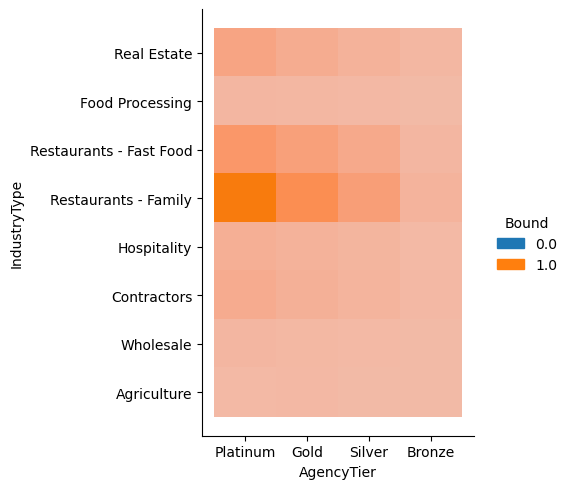

In [57]:
sns.displot(policies[['Bound','IndustryType', 'AgencyTier']],x='AgencyTier', y='IndustryType', hue='Bound')
plt.show()

Restaurants in general seem to be Bound more often, especially family restaurants. Also, higher AgencyTier corresponds to better binding. 

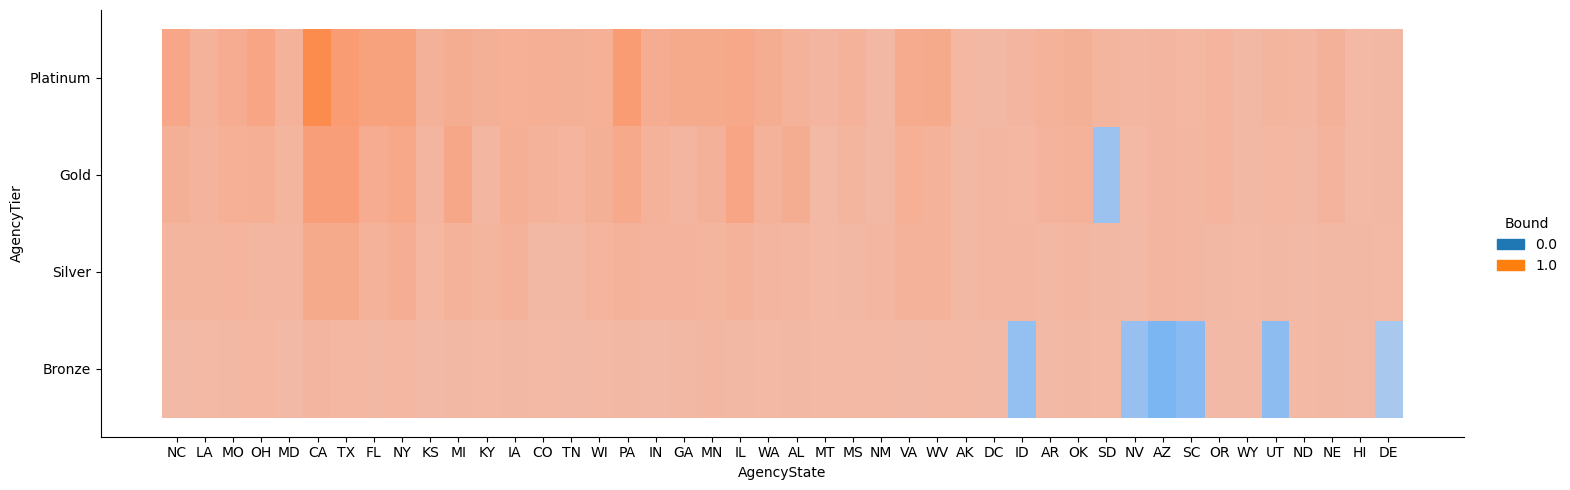

In [58]:
sns.displot(policies[['Bound','AgencyState', 'InsuredState','IndustryType', 'AgencyTier']],
            x='AgencyState', y='AgencyTier', hue='Bound', aspect = 3)
plt.show()

Last, let's look at Insured State and see if there's some differences with Agency State.

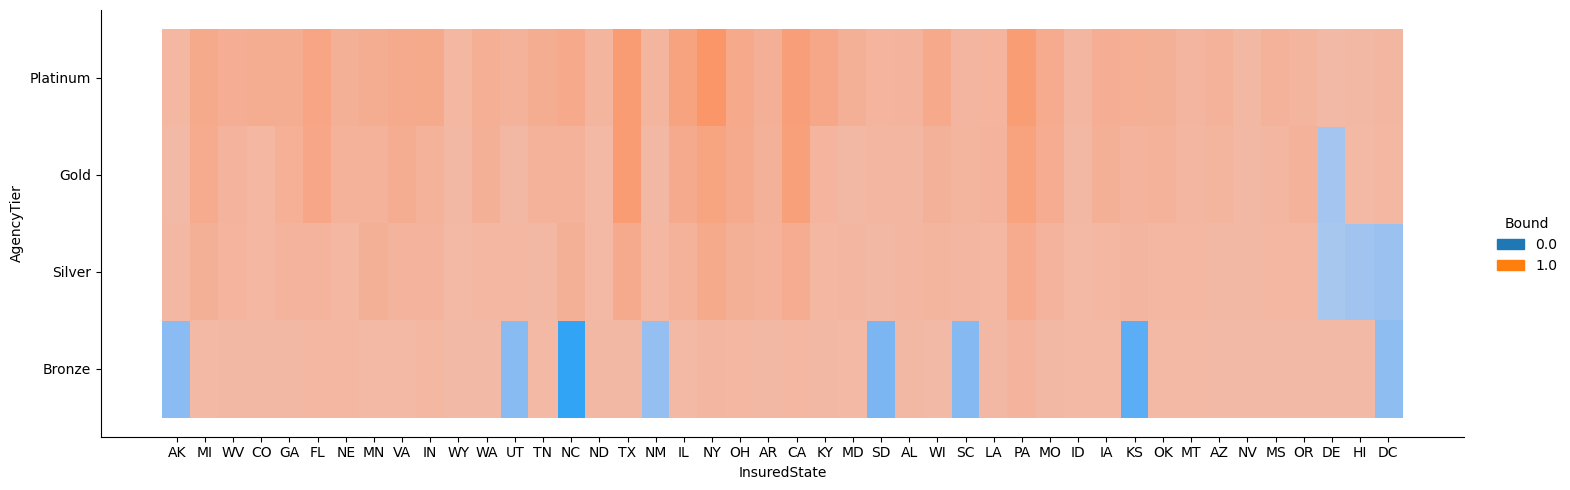

In [59]:
sns.displot(policies[['Bound','AgencyState', 'InsuredState','IndustryType', 'AgencyTier']],
            x='InsuredState', y='AgencyTier', hue='Bound', aspect = 3)
plt.show()

There are for sure some differences that are of note; it's too many too list individually. Knowing the data/business better would help.

### 5. Geographic analysis

In [60]:
import folium
from folium import plugins
import geopandas as gpd

Reference: https://towardsdatascience.com/how-to-step-up-your-folium-choropleth-map-skills-17cf6de7c6fe

In [61]:
# We import the geoJSON file. 
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/us-states.json"

# We read the file and print it.
geoJSON_df = gpd.read_file(state_geo)
#geoJSON_df.head()

In [62]:
# Next we grab the states and put them in a list and check the length.
geoJSON_states = list(geoJSON_df.id.values)
len(geoJSON_states)

50

In [63]:
# Let's check which states are missing.
missing_states = py.setdiff1d(geoJSON_states,list(policies['InsuredState']))
missing_states

array(['CT', 'MA', 'ME', 'NH', 'NJ', 'RI', 'VT'], dtype='<U2')

In [64]:
# we rename the column from id to state in the geoJSON_df so we can merge the two data frames.
geoJSON_df = geoJSON_df.rename(columns = {"id":"state"})
# similar for our policies DF, although first we will reduce it to just the relevant columns
policies_geo = policies[['InsuredState', 'Bound']]
policies_geo = policies_geo.rename(columns = {"InsuredState":"state"})
# Next we merge our sample data (df) and the geoJSON data frame on the key id.
final_df = geoJSON_df.merge(policies_geo, on = "state")
#final_df.head()

In [65]:
# Last, we take the mean of the bound variable 
state_bound_means = final_df.groupby(['state'], as_index=False).mean()
state_bound_means2 = geoJSON_df.merge(state_bound_means, on = "state")
state_bound_means2.head()

,state,name,geometry,Bound
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",0.109489
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",0.096154
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",0.141414
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",0.175182
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",0.121622


In [66]:
# Initialize folium map.
sample_map = folium.Map(location=[48, -102], zoom_start=3)
#sample_map

In [67]:
# Set up Choropleth map
folium.Choropleth(
geo_data=state_bound_means2,
data=state_bound_means2,
columns=['state',"Bound"],
key_on="feature.properties.state",
fill_color='YlGnBu',
fill_opacity=1,
line_opacity=0.2,
legend_name="Bound",
smooth_factor=0,
Highlight= True,
line_color = "#0000",
name = "Bound",
#show=False,
overlay=True,
nan_fill_color = "White"
).add_to(sample_map)

sample_map

![Insurance_Bound_map.png](attachment:Insurance_Bound_map.png)

- I don't see any patterns here, e.g. coastal vs. MidWest states, 
- Although certain chunks are consistent and 
- There are no policies in the New England area.

### 5. Modeling & next steps

On a bigger dataset, I would check for sparsity and adjust my methods accordingly (e.g. use the feature hashing trick). I might end up using FPGrowth (rather than PCA) for picking out the feature set. The advantage of FPGrowth over apriori is it only saves trees whose combination meet support (saving on memory).

With XGBoost, I would look at feature importance via SHAP importance & partial dependence plots, and other visualizations.

XGBoost also takes care of gradient descent which we would have to tune in other models (although it does save on memory over tree implementations) .

In a real environment, to build a pipeline/model, I would create test, train, and validation sets from the data. I would choose pyspark with MLlib if it was really big, and import a distributed implementation for the algorithm. Hyperfeature tuning might come in the form of *sklearn gridsearch*.

Another important consideration would be to balance classes (bound = 0 vs. 1) to focus on accuracy of the Bound = 1 outcome (instead of the model as a whole). Something like (borrowed from a previous pySpark project of mine):

In [68]:
'''def balance_classes(rdd, ratio = 0.128):
    keep_ratio = ratio/(1-ratio)
    keep, discard = rdd.filter(lambda x:  x[0]=='0').randomSplit([keep_ratio,  1-keep_ratio], seed = 1)
    minority = rdd.filter(lambda x:  x[0]=='1')
    balanced_rdd = keep.union(minority)
    return balanced_rdd

tinyRDD_bal = balance_classes(tinyRDD).cache()
trainRDD_bal = balance_classes(trainRDD).cache()'''

"def balance_classes(rdd, ratio = 0.128):\n    keep_ratio = ratio/(1-ratio)\n    keep, discard = rdd.filter(lambda x:  x[0]=='0').randomSplit([keep_ratio,  1-keep_ratio], seed = 1)\n    minority = rdd.filter(lambda x:  x[0]=='1')\n    balanced_rdd = keep.union(minority)\n    return balanced_rdd\n\ntinyRDD_bal = balance_classes(tinyRDD).cache()\ntrainRDD_bal = balance_classes(trainRDD).cache()"

Depending on the use case, we could use an F-1 score or F-beta score from sklearn.metrics to evaluate the model. For our fairly well-balanced dataset, we could use sklearn.metrics.precision_recall_fscore_support, particularly if we are looking at both Bound = 0 and = 1 possible outcomes in our usecase. Other possibilities inlcude leave-n-out cross-validation, which could be very helpful on a speciality insurance dataset where bootstrapping was used in the first place to model. Mutual information could be a could metric for large (e.g. health insurance) data sets. 

For the actual model itself, LogReg and LDA are simple, understandable, and easy to train.